# 19. AMES HOUSING: REVISITING OUTLIERS
---

## 1. Introducing the Data

In [1]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", 99)
pd.set_option("display.max_rows", 999)
pd.set_option('precision', 3)

ames = pd.read_csv('data/Ames_Housing2_train14')
holdout = pd.read_csv('data/Ames_Housing2_test14')
print(ames.shape)
print(holdout.shape)
ames.head()

(2344, 14)
(586, 14)


,Overall Qual,Gr Liv Area,1st Flr SF,2nd Flr SF,BsmtFin SF 1,Garage Cars,Lot Area,Full Bath,Kitchen Qual,Year Built,Year Remod/Add,Bsmt Qual,Lot Frontage,SalePrice
0,7,-0.244,0.559,-0.781,-0.979,2,0.034,2,5,0.181,-0.381,7,0.469,152000.0
1,5,1.255,0.013,1.481,-0.428,2,2.307,2,5,-0.116,-0.814,5,0.410,185000.0
2,4,-0.533,0.180,-0.781,-0.979,2,-0.036,2,5,-0.280,-1.055,0,0.014,101800.0
3,4,-0.898,-0.298,-0.781,-0.979,2,-0.364,2,5,-0.709,-1.632,0,-0.441,90000.0
4,4,0.413,-0.140,0.624,-0.979,0,-0.311,2,3,-1.665,-1.632,3,-0.305,94550.0


In [2]:
X_train = ames.drop(['SalePrice'], axis=1)
y_train = ames['SalePrice']
X_test = holdout.drop(['SalePrice'], axis=1)
y_test = holdout['SalePrice']

X_train.shape, X_test.shape

((2344, 13), (586, 13))

## 2. Visualizing Outliers in the `X_train`
Since data are scaled, it actually makes it easier to visualize the outliers

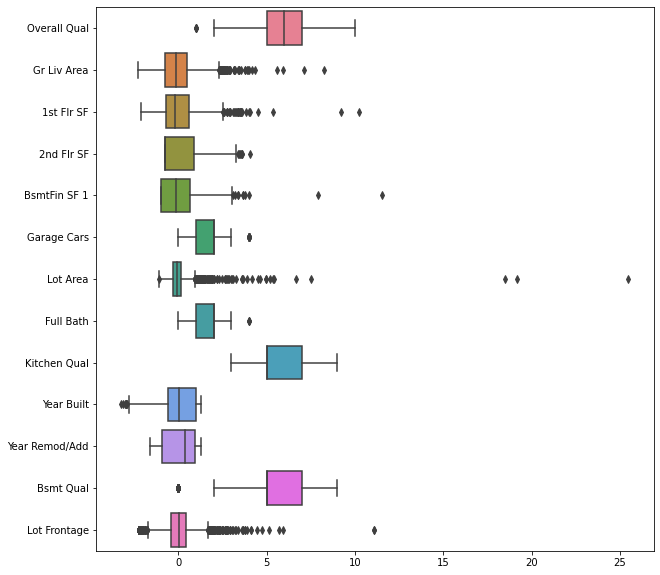

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
ax = sns.boxplot(data=X_train, orient="h", palette="husl")

## 3. Capping Outliers and Visualizing the Effect

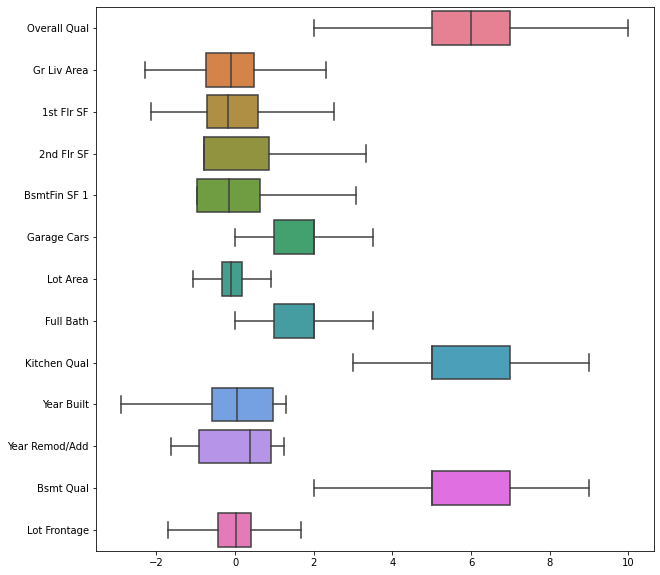

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

class OutlierCapper(BaseEstimator, TransformerMixin):    
    def __init__(self):
        self    
        
    def fit(self, df, y = None):               
        return self

    def transform(self, df):        
        df = df.copy()
        cols = df.columns
        for col in cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            LB = Q1 - (IQR * 1.5)
            UB = Q3 + (IQR * 1.5)
            df.loc[df[col] > UB, col] = UB
            df.loc[df[col] < LB, col] = LB
        return df
    
outliar = OutlierCapper()
X_train_ = outliar.fit_transform(X_train)

plt.figure(figsize=(10,10))
ax = sns.boxplot(data=X_train_, orient="h", palette="husl")

The boxplots look very clean. An interesting observation though: the features that were not scaled are the one at the higher end of the overall data range. Maybe it's too bad to scale ordinal data too!
## 4. Training Random Forest after Capping Outliers

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

ranfo = RandomForestRegressor(max_depth=8, min_samples_leaf=1,
                            min_samples_split=4)
ranfo_mse = cross_val_score(ranfo, X_train_, y_train, cv=10, n_jobs=-1, 
                             scoring="neg_mean_squared_error") 
ranfo_rmse = np.sqrt(np.absolute(ranfo_mse))
print('RMSE:', ranfo_rmse)
print('Avg_RMSE:', ranfo_rmse.mean())
print('Std_RMSE:', ranfo_rmse.std())

RMSE: [23972.31940202 31384.64782809 23351.80049968 26427.24688335
 26786.90594127 26696.95469792 35001.9668865  27572.01394611
 25841.08594234 23150.43703898]
Avg_RMSE: 27018.537906625126
Std_RMSE: 3502.6288968540894


So the average RMSE goes up by a hair but the std deviation even more (almost 10%). This suggests that we need to look into our target attribute. We actually did this in `14.9` and found that there are 0 values below the lower boundary and 107 above the upper boundary. Let's visualize again what the target looks like
- `ames_1`: before capping target outliers
- `ames_2`: after capping target outliers
- `ames_3`: after removing target outliers
## 5. Visualizing Outliers in the Target Column

In [6]:
ames_1 = ames.copy()
ames_1['SalePrice'].max()

755000.0

In [7]:
ames_2 = outliar.fit_transform(ames_1)
print(len(ames_2))
print(ames_2['SalePrice'].min())
print(ames_2['SalePrice'].max())

2344
12789.0
331500.0


In [8]:
UB = ames_2['SalePrice'].max()
ames_3 = ames_2[ames_2['SalePrice']!=UB]
print(len(ames_3))
print(ames_3['SalePrice'].min())
print(ames_3['SalePrice'].max())

2237
12789.0
330000.0


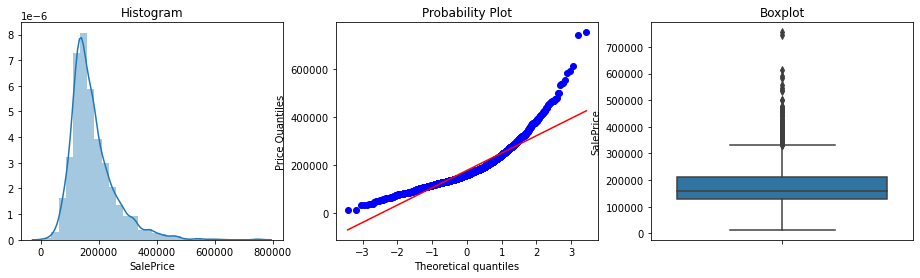

In [9]:
import scipy.stats as stats

def diagnostic_plots(df, variable):   
    plt.figure(figsize=(16, 4))
   
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')
   
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Price Quantiles')
    
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()
    
diagnostic_plots(ames_1, 'SalePrice')

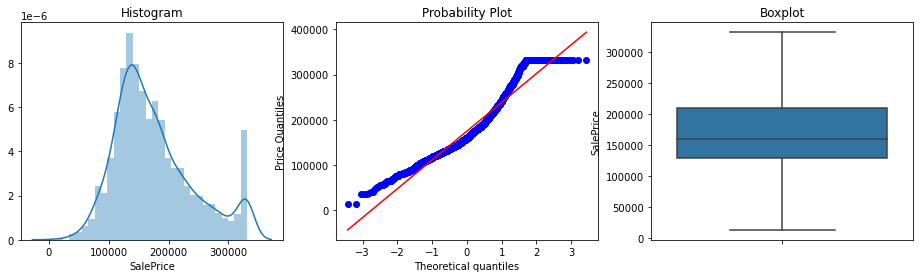

In [10]:
diagnostic_plots(ames_2, 'SalePrice')

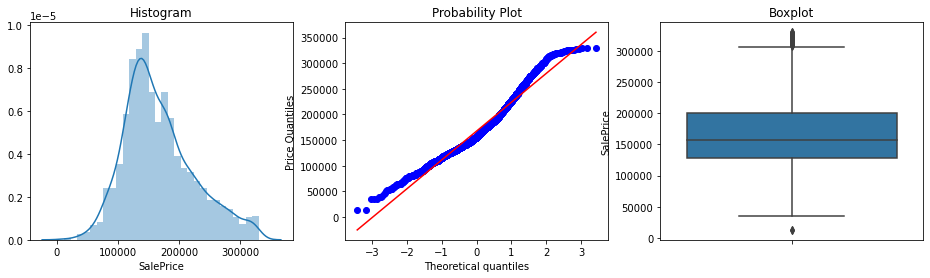

In [11]:
diagnostic_plots(ames_3, 'SalePrice')

In [12]:
ames_3.max()-ames_3.min()

Overall Qual           8.000
Gr Liv Area            4.595
1st Flr SF             4.653
2nd Flr SF             4.104
BsmtFin SF 1           4.059
Garage Cars            3.500
Lot Area               1.997
Full Bath              3.500
Kitchen Qual           6.000
Year Built             4.203
Year Remod/Add         2.887
Bsmt Qual              7.000
Lot Frontage           3.403
SalePrice         317211.000
dtype: float64

## 6. Random Forest and KNN after Removing Target Outliers

In [13]:
X_train_3 = ames_3.drop(['SalePrice'], axis=1)
y_train_3 = ames_3['SalePrice']
X_train_3.shape, y_train_3.shape

((2237, 13), (2237,))

In [14]:
ranfo = RandomForestRegressor(max_depth=8, min_samples_leaf=1,
                            min_samples_split=4)
ranfo_mse = cross_val_score(ranfo, X_train_3, y_train_3, cv=10, n_jobs=-1, 
                             scoring="neg_mean_squared_error") 
ranfo_rmse = np.sqrt(np.absolute(ranfo_mse))
print('RMSE:', ranfo_rmse)
print('Avg_RMSE:', ranfo_rmse.mean())
print('Std_RMSE:', ranfo_rmse.std())

RMSE: [21419.50464832 21249.71898089 22333.23427962 18960.78757893
 23820.68220526 21532.57088104 24059.61322842 21634.34313814
 24231.9276909  22416.18067214]
Avg_RMSE: 22165.85633036624
Std_RMSE: 1517.7767720458114


In [15]:
from sklearn.neighbors import KNeighborsRegressor

knn13 = KNeighborsRegressor(algorithm='ball_tree', n_neighbors=7, 
                        p=1, weights='distance')
knn13_mse = cross_val_score(knn13, X_train_3, y_train_3, cv=10, n_jobs=-1, 
                             scoring="neg_mean_squared_error") 
knn13_rmse = np.sqrt(np.absolute(knn13_mse))
print('RMSE:', knn13_rmse)
print('Avg_RMSE:', knn13_rmse.mean())
print('Std_RMSE:', knn13_rmse.std())

RMSE: [21717.1287166  23423.86399544 23575.33878679 18829.30307991
 23022.08192654 21743.86392948 24073.54158081 21952.2849837
 23142.2409508  22157.9727522 ]
Avg_RMSE: 22363.762070229033
Std_RMSE: 1416.367395726515


The standard deviation is cut in half while the RMSE is also improved by about 15% compared to when we did nothing with outliers (previous chapter)

## 7. Processing the Test Set

In [16]:
holdout_1 = holdout.copy()
holdout_1['SalePrice'].max()

625000.0

In [17]:
holdout_2 = outliar.transform(holdout_1)
print(len(holdout_2))
print(holdout_2['SalePrice'].min())
print(holdout_2['SalePrice'].max())

586
44000.0
375937.5


In [18]:
UB = holdout_2['SalePrice'].max()
holdout_3 = holdout_2[holdout_2['SalePrice']!=UB]
print(len(holdout_3))
print(holdout_3['SalePrice'].min())
print(holdout_3['SalePrice'].max())

559
44000.0
374000.0


In [19]:
X_test_3 = holdout_3.drop(['SalePrice'], axis=1)
y_test_3 = holdout_3['SalePrice']
X_test_3.shape, y_test_3.shape

((559, 13), (559,))

## 8. Testing Random Forest and KNN
#### Random Forest

In [20]:
from sklearn.metrics import mean_squared_error

ran13 = RandomForestRegressor(max_depth=8, min_samples_leaf=1,
                            min_samples_split=4)
ran13.fit(X_train_3, y_train_3)
y_pred_3 = ran13.predict(X_train_3)
mse13 = mean_squared_error(y_train_3, y_pred_3)
rmse13 = np.sqrt(mse13)
print('MSE_train:', mse13)
print('RMSE_train:', rmse13)

MSE_train: 213844147.4946966
RMSE_train: 14623.410939131014


In [21]:
y_pred_t = ran13.predict(X_test_3)
mse_t = mean_squared_error(y_test_3, y_pred_t)
rmse_t = np.sqrt(mse_t)
print('MSE_test:', mse_t)
print('RMSE_test:', rmse_t)

MSE_test: 526970116.743148
RMSE_test: 22955.829689713853


#### KNN

In [22]:
knn13 = KNeighborsRegressor(algorithm='ball_tree', n_neighbors=7, 
                        p=1, weights='distance')
knn13.fit(X_train_3, y_train_3)
y_pred13 = knn13.predict(X_train_3)
mse13 = mean_squared_error(y_train_3, y_pred13)
rmse13 = np.sqrt(mse13)
print('MSE_train:', mse13)
print('RMSE_train:', rmse13)

MSE_train: 36049.419758605276
RMSE_train: 189.86684744474292


In [23]:
y_pred = knn13.predict(X_test_3)
mse_t = mean_squared_error(y_test_3, y_pred)
rmse_t = np.sqrt(mse_t)
print('MSE_test:', mse_t)
print('RMSE_test:', rmse_t)

MSE_test: 516618624.32846534
RMSE_test: 22729.24601319774


Look at that! Random Forest was always the better model until we worked on outliers and KNN edged it out both on the training set and on the test set. 

#### Best Model:
- `KNeighborsRegressor`(algorithm='ball_tree', n_neighbors=7, p=1, weights='distance')
                        
- **`RMSE_test: 22,729`**

## 9. Computing the  95% Confidence Interval 

In [24]:
confidence = 0.95
KNN_squared_errors = (y_pred - y_test_3)**2
KNN_conf = np.sqrt(stats.t.interval(confidence, len(KNN_squared_errors) - 1,
                                    loc=KNN_squared_errors.mean(),
                                    scale=stats.sem(KNN_squared_errors)))
KNN_conf

array([20256.96442567, 24957.81723056])

In [25]:
Ran_squared_errors = (y_pred_t - y_test_3)**2
Ran_conf = np.sqrt(stats.t.interval(confidence, len(Ran_squared_errors) - 1,
                                    loc=Ran_squared_errors.mean(),
                                    scale=stats.sem(Ran_squared_errors)))
Ran_conf

array([20808.6890508 , 24918.64148531])

Both of our models' errors fall within the 95% confidence interval range, which is great!